<img src="data/photutils_banner.svg" width=500 alt="Photutils logo" style="margin-left: 0;">

<div class="alert alert-block alert-info">
<h2 style="margin-top: 0">In this notebook, we will cover:</h2>

- The basics of image segmentation
- Creating and handling a catalog from a segmented image

This notebook builds on the previous tutorials for Astropy Units/Quantities, Coordinates, FITS, and Tables.
</div>

## Preliminaries

In [1]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt

# Change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading science data and error arrays from FITS files located in the [**data/**](data) subdirectory.  The FITS files contain 2D cutout images from the [Hubble Extreme-Deep Field (XDF)](https://archive.stsci.edu/prepds/xdf/) taken with the [Wide Field Camera 3 (WFC3)](https://www.stsci.edu/hst/instrumentation/wfc3) IR channel in the F160W filter (centered at ~1.6 $\mu m$).

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from photutils.utils import calc_total_error

sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

data = sci_hdulist[0].data.astype(float)
error = rms_hdulist[0].data.astype(float)
hdr = sci_hdulist[0].header
wcs = WCS(hdr)

eff_gain = hdr['TEXPTIME']  # exposure time from the FITS header
total_error = calc_total_error(data, error, eff_gain)

In [7]:
wcs

/Users/momcheva/miniconda3/envs/astropy_sofia/lib/python3.11/site-packages/astropy/wcs/wcs.py:3137: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.122751  -27.805089  
CRPIX : 2010.5  -2344.5  
PC1_1 PC1_2  : -1.6666666666667e-05  0.0  
PC2_1 PC2_2  : 0.0  1.66666666666667e-05  
CDELT : 1.0  1.0  
NAXIS : 200  200

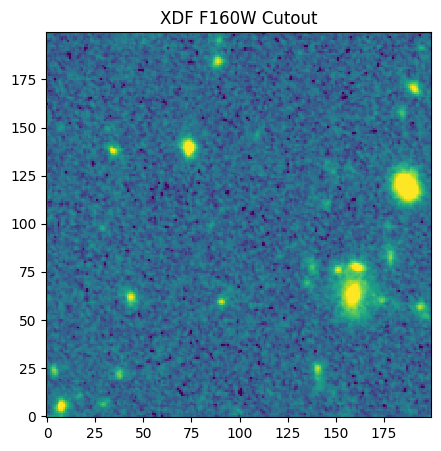

In [8]:
from astropy.visualization import simple_norm

plt.figure(figsize=(5, 5))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm)
plt.title('XDF F160W Cutout');

# Image Segmentation

Image segmentation is a process of assigning a label to every pixel in an image such that pixels with the same label are part of the same source. Detected sources must have a minimum number of connected pixels that are each greater than a specified threshold value in an image.

The threshold level is usually defined as some multiple of the background noise (sigma level) above the background. This can be specified either as a per-pixel threshold image or a single value for the whole image.

The image is usually filtered before thresholding to smooth the noise and maximize the detectability of objects with a shape similar to the filter kernel.

First, we need to subtract the background from the image. Even though the background has already been subtracted from this dataset, we'll still perform that step as an example for other datasets.

In this example, we’ll use the `Background2D` class to produce a background and background noise image.  The background rms will be used later to define the detection threshold.

In [9]:
from photutils.background import Background2D, MedianBackground

bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

In [11]:
bkg.background.shape

(200, 200)

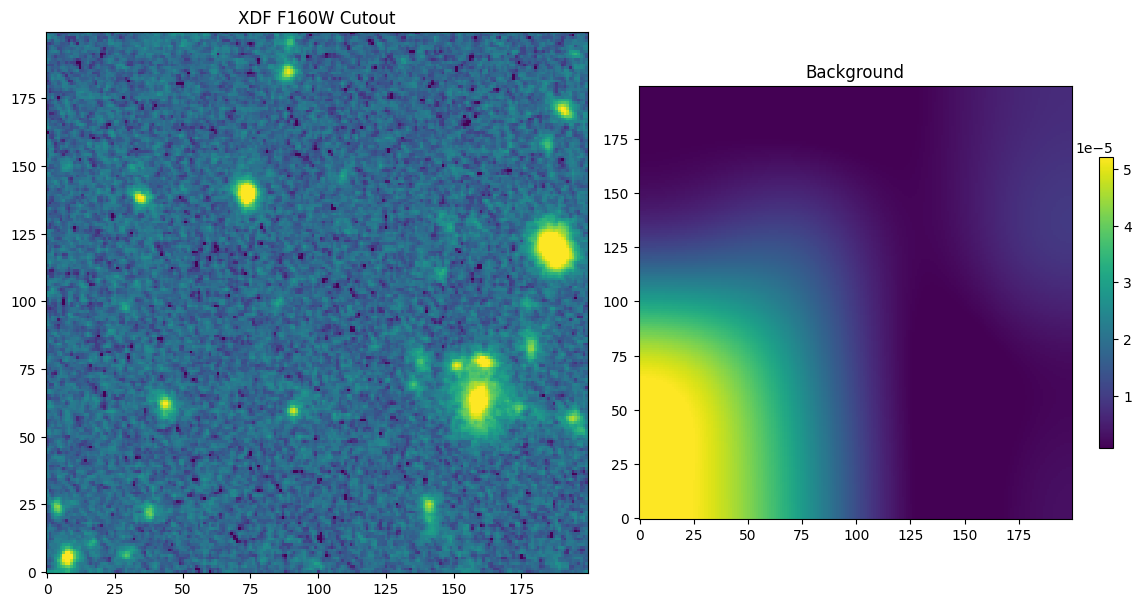

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
norm = simple_norm(data, 'sqrt', percent=99.)
ax1.imshow(data, norm=norm)
ax1.set_title('XDF F160W Cutout');
pcm = ax2.imshow(bkg.background)
ax2.set_title('Background')
fig.colorbar(pcm, ax=ax2, shrink=0.3)
fig.tight_layout()

After subtracting the background, we need to define the detection threshold. In this example, we’ll define a 2D detection threshold image using the background RMS image calculate above. We set the threshold at the 2.0$\sigma$ (per pixel) noise level (above the background).

In [14]:
threshold = 2.0 * bkg.background_rms

Next, let’s convolve the background-subtracted data with a 2D Gaussian kernel with a FWHM of 3 pixels.

In [15]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

kernel = make_2dgaussian_kernel(3.0, size=9)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

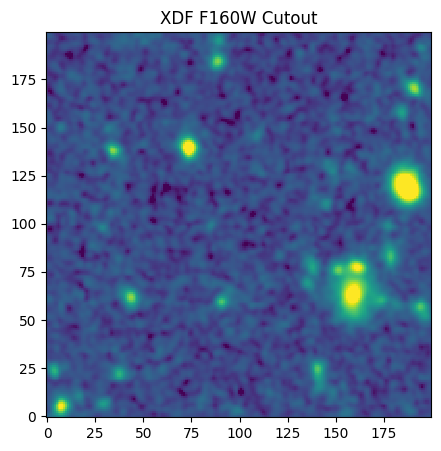

In [16]:
plt.figure(figsize=(5, 5))
norm = simple_norm(convolved_data, 'sqrt', percent=99.)
plt.imshow(convolved_data, norm=norm)
plt.title('XDF F160W Cutout');

Now we are ready to detect the sources in the background-subtracted convolved image. Let’s find sources that have 5 connected pixels that are each greater than the corresponding pixel-wise threshold level defined above (i.e., 2.0$\sigma$ per pixel above the background). For this we use the [detect_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html) function.

Note that by default “connected pixels” means “8-connected” pixels, where pixels touch along their edges or corners. One can also use “4-connected” pixels that touch only along their edges by setting connectivity=4:

"8-connected" pixels touch along their edges or corners. "4-connected" pixels touch along their edges. For reference, SourceExtractor uses "8-connected" pixels.

```
8-connected      4-connected
(default)

  1 1 1            0 1 0
  1 x 1            1 x 1
  1 1 1            0 1 0
```

In [17]:
from photutils.segmentation import detect_sources

npixels = 5
segment_map = detect_sources(convolved_data, threshold, npixels)

print('Found {0} sources'.format(segment_map.nlabels))

Found 25 sources


The result is a segmentation image ([SegmentationImage](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage) object).  The segmentation image is an array with the same size as the science image in which each detected source is labeled with a unique integer value (>= 1).  Background pixels have a value of 0.  As a simple example, a segmentation map containing two distinct sources (labeled 1 and 2) might look like this:

```
0 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 2 0
1 1 1 1 0 0 0 2 2 2
1 1 1 0 0 0 2 2 2 2
1 1 1 1 0 0 0 2 2 0
1 1 0 0 0 0 2 2 0 0
0 1 0 0 0 0 2 0 0 0
0 0 0 0 0 0 0 0 0 0
```
where all of the pixels labeled `1` belong to the first source, all those labeled `2` belong to the second, and all those labeled `0` are background pixels.

Let's display the segmentation image.

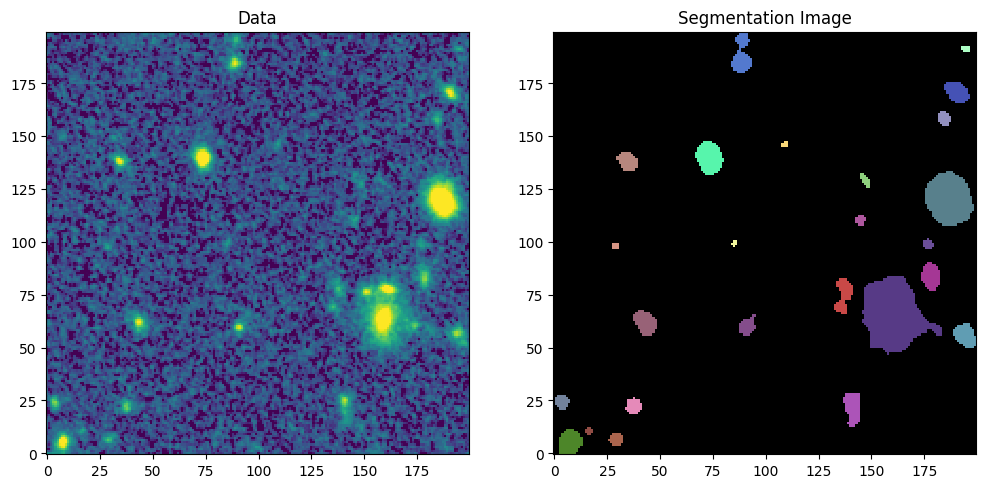

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.imshow(data, norm=norm)
lbl1 = ax1.set_title('Data')
segment_map.imshow(ax=ax2)
lbl2 = ax2.set_title('Segmentation Image')

## Source deblending

Comparing the data array with the segmentation image, we see that several detected sources were blended together.  We can deblend them using the [deblend_sources](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html#photutils.segmentation.deblend_sources) function, which uses a combination of multi-thresholding and watershed segmentation.

The amount of deblending can be controlled with the two `deblend_sources` keywords `nlevels` and `contrast`:

- `nlevels` is the number of multi-thresholding levels to use
- `contrast` is the fraction of the total source flux that a local peak must have to be considered as a separate object

Found 31 sources


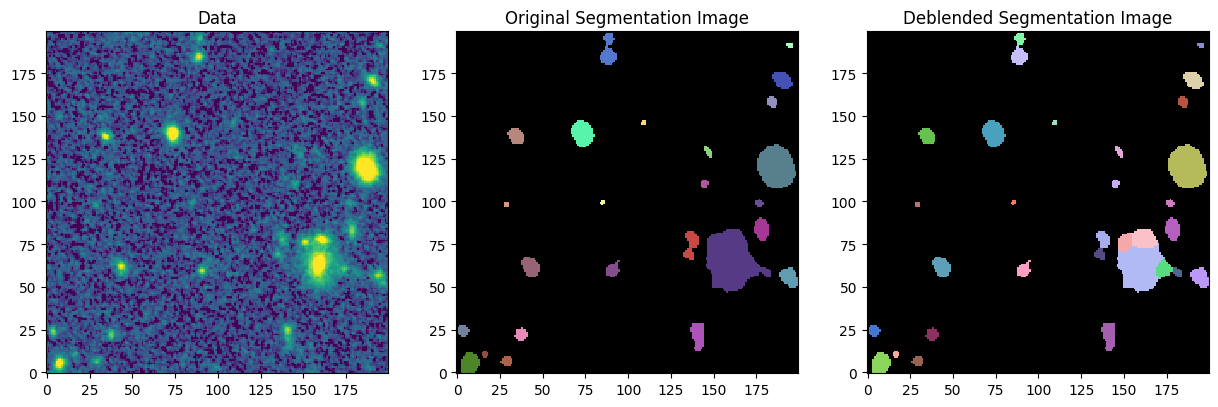

In [19]:
from photutils.segmentation import deblend_sources

segment_map2 = deblend_sources(convolved_data, segment_map, npixels,
                               contrast=0.001, nlevels=32, progress_bar=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(data, norm=norm)
ax1.set_title('Data')
segment_map.imshow(ax=ax2)
ax2.set_title('Original Segmentation Image')
segment_map2.imshow(ax=ax3)
ax3.set_title('Deblended Segmentation Image')

print('Found {0} sources'.format(segment_map2.nlabels))

From the segmentation image, we observe that the sources were successfully deblended. We have 6 additional unique sources.

## SourceFinder class

The `SourceFinder` class is a convenience class that combines the functionality of `detect_sources` and `deblend_sources`. After defining the `SourceFinder` object with the desired detection and deblending parameters, you call it with the background-subtracted (convolved) image and threshold.

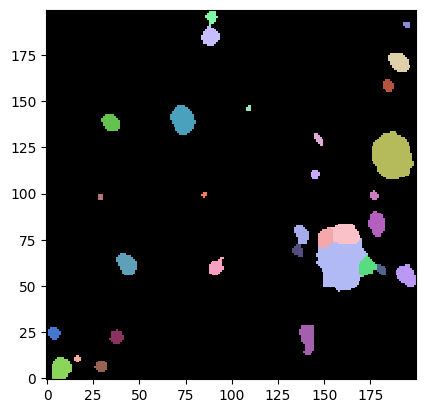

In [20]:
from photutils.segmentation import SourceFinder

finder = SourceFinder(npixels=npixels, deblend=True, progress_bar=False)
segment_map3 = finder(convolved_data, threshold)
axim = segment_map3.imshow()

## Modifying a Segmentation Image

The `SegmentationImage` object provides several methods that can be used to visualize or modify itself (e.g., combining labels, removing labels, removing border segments) prior to measuring source photometry and other source properties, including:

* `reassign_label()`: Reassign one or more label numbers.

* `relabel_consecutive()`: Reassign the label numbers consecutively, such that there are no missing label numbers.

* `keep_labels()`: Keep only the specified labels.

* `remove_labels()`: Remove one or more labels.

* `remove_border_labels()`: Remove labeled segments near the image border.

* `remove_masked_labels()`: Remove labeled segments located within a masked region.

* `outline_segments()`: Outline the labeled segments for plotting.

## Photometry, Centroids, and Shape Properties

The [SourceCatalog](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog) class is the primary tool for measuring the photometry, centroids, and shape/morphological properties of sources defined in a segmentation image. In its most basic form, it takes as input the (background-subtracted) image and the segmentation image. Usually the convolved image is also input, from which the source centroids and shape/morphological properties are measured (if not input, the unconvolved image is used instead).

Let’s continue our example from above and measure the properties of the detected sources.

In [21]:
import astropy.units as u
from photutils.segmentation import SourceCatalog

unit = u.electron / u.s
catalog = SourceCatalog(data << unit, segment_map3, error=total_error << unit,
                        convolved_data=convolved_data << unit, wcs=wcs)
catalog

<photutils.segmentation.catalog.SourceCatalog>
Length: 31
labels: [ 1  2  3  4  5 ... 27 28 29 30 31]

In [ ]:
catalog.

Our `catalog` variable is a `SourceCatalog` object. The properties of each source can be accessed using `SourceCatalog` attributes or they can be output to an Astropy `QTable` using the `to_table()` method.

Here we’ll use the `to_table()` method to generate a `QTable` of source photometry and properties. Each row in the table represents a source. The columns represent the calculated source properties. The label column corresponds to the label value in the input segmentation image.

Please see the [SourceCatalog documentation](https://photutils.readthedocs.io/en/latest/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog) for a complete list of the available source properties.

In [22]:
catalog_tbl = catalog.to_table()
catalog_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.573600053905634,5.106964104158455,"53.16045808560151,-27.765907108640302",3,13,0,11,109.0,2.575462630752001,2.1555705645317205,67.84697640313266,0.5472573199544688,0.0005068250775366323,0.013272468788272818,0.0,0.35981275577250926,0.009482725190922227,0.39818556238606667,0.013270650831634026
2,29.369990696675536,6.469313651144928,"53.16004753417832,-27.765884513599",26,32,4,9,33.0,1.5552121581010696,1.4217465025317169,16.904320737349675,0.4053045891741622,0.00037815432450307373,0.003982343548098235,0.0,0.05586856944265017,0.005204538419719841,0.07851655509867138,0.009336095761263973
3,16.475764968631726,10.499351499050908,"53.160290378766454,-27.765817280965667",15,18,9,12,12.0,0.9309367685464387,0.9276515635834229,40.53357044638353,0.08393684763815415,0.0006857453572592931,0.0025910796557582216,0.0,0.01897048463433748,0.003134507222395618,0.0434744368956239,0.009709328550753252
4,141.04702951252528,22.22568518562014,"53.15794396836625,-27.765622456097887",137,144,13,28,100.0,3.912193451340148,1.7101580098801454,-84.23702457773423,0.8993957391242778,0.0005911461010370544,0.006730295291895061,0.0,0.20735797311905912,0.009051625170083856,0.25288588574957704,0.016276411247747483
5,37.677304952430205,22.147209862270678,"53.15989097337343,-27.765623257405355",34,41,19,26,45.0,1.7285630280092903,1.655253662049567,80.6371050004469,0.28813626751881416,0.00043656265127694165,0.004659340288049956,0.0,0.09012391894947834,0.006086535914578587,0.117283237903785,0.010214624575151572
6,3.7844232512314817,23.972238346974283,"53.16052934695438,-27.765592668239215",1,7,21,27,38.0,1.6509253484538644,1.4512128181474973,-69.96601154623951,0.4767665633231746,5.5351601986330934e-05,0.005221896195507725,0.0,0.07937658694208949,0.0056047229365901305,0.0901051622939802,0.008537202057700904
7,194.406682337675,55.62583601500085,"53.15693874569289,-27.76506603812639",189,199,50,61,94.0,2.8558249127544646,2.060505749656938,-54.45386910389452,0.6924041912265645,0.0003740052862359113,0.006073460524203859,0.0,0.2021733789068592,0.008856089537766381,0.23944868269466008,0.01556260398948671
8,43.39404412722461,61.54735545501103,"53.159783072870916,-27.764966617496196",38,48,56,67,97.0,2.7000922946328396,2.033255024934337,-59.01114954166641,0.6579842669281907,0.0003589028756223554,0.008730223143216179,0.0,0.2335813730882946,0.008965505266771019,0.259002155411701,0.015452883023151948


Let's save this table to an ESCV file so it can be used later in the exercises.

In [23]:
catalog_tbl.write('xdf_f160w_catalog.ecsv', overwrite=True)

Let's also save the `SegmentationImage` to a FITS file.

In [24]:
fits.writeto('xdf_f160w_segm.fits', segment_map3.data, overwrite=True)

We can also access the source properties as attributes of the `SourceCatalog` object.

In [25]:
catalog

<photutils.segmentation.catalog.SourceCatalog>
Length: 31
labels: [ 1  2  3  4  5 ... 27 28 29 30 31]

In [26]:
catalog.xcentroid

array([  7.57360005,  29.3699907 ,  16.47576497, 141.04702951,
        37.67730495,   3.78442325, 194.40668234,  43.39404413,
        91.22513857, 178.30779418,  28.97143904, 176.96293753,
        85.18071464, 144.94460138, 186.90452082, 147.17963536,
        73.59616117,  34.65248843, 109.10850172, 184.40366112,
       190.58697758, 194.62260557, 159.18942496, 180.9864855 ,
       172.74645485, 151.03476832, 160.99043165, 135.69112687,
       137.73950334,  88.61695181,  89.08632767])

In [27]:
catalog.eccentricity

<Quantity [0.54725732, 0.40530459, 0.08393685, 0.89939574, 0.28813627,
           0.47676656, 0.69240419, 0.65798427, 0.66627343, 0.77270244,
           0.17019717, 0.47830931, 0.67445212, 0.39020462, 0.60234895,
           0.9114653 , 0.60293655, 0.59571795, 0.62937981, 0.59770145,
           0.68814959, 0.699434  , 0.53224138, 0.79306421, 0.45033681,
           0.59877399, 0.65696832, 0.5710872 , 0.76676461, 0.37944663,
           0.59210247]>

In [28]:
# isophotal flux
catalog.segment_flux

<Quantity [0.35981276, 0.05586857, 0.01897048, 0.20735797, 0.09012392,
           0.07937659, 0.20217338, 0.23358137, 0.11480752, 0.18963006,
           0.01587596, 0.02892154, 0.01019851, 0.03192571, 2.76661943,
           0.0305153 , 0.73028864, 0.1834566 , 0.01243153, 0.05901076,
           0.23978421, 0.01951278, 1.92989125, 0.03047591, 0.14641533,
           0.18937596, 0.50015192, 0.05337949, 0.10491505, 0.18240648,
           0.05447788] electron / s>

In [30]:
f160w_zpt = 25.9463  # HST/WFC3 F160W ABmag zero point for flux in e-/s

# NOTE that the log10() function can be applied only to dimensionless quantities,
# so we use the value attribute for Quantity objects to remove the units of the aperture sum
abmag = -2.5 * np.log10(catalog.segment_flux.value) + f160w_zpt

catalog.add_extra_property('f160w_abmag', abmag << u.mag, overwrite=True)
catalog.f160w_abmag

ValueError: f160w_abmag cannot be set because it is a built-in attribute

Next, let's plot the elliptical Kron apertures (based on the shapes of each source) for each source.

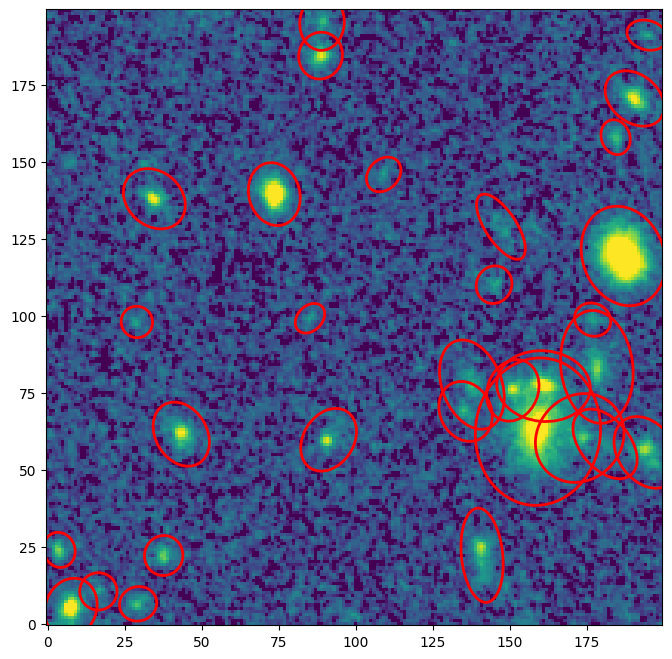

In [31]:
plt.figure(figsize=(8, 8))
plt.imshow(data, norm=norm)
for obj in catalog:
    obj.kron_aperture.plot(color='red', lw=2)

In [32]:
from regions import CircleSkyRegion, Regions
reglist = []
for coord in catalog.sky_centroid:
    region = CircleSkyRegion(coord, radius=0.5/3600. * u.deg)
    reglist.append(region)
regs = Regions(reglist)
regs.write('xdf_region.reg', format='ds9', overwrite=True)

The `SourceCatalog` object can also be indexed or sliced to select a subset of sources.

In [33]:
objs = catalog[0:5]  # the first 5 sources
objs

<photutils.segmentation.catalog.SourceCatalog>
Length: 5
labels: [1 2 3 4 5]

Subsets can also be created using a label number or list of labels.

In [34]:
labels = [1, 2, 5, 7, 21]
objs = catalog.get_labels(labels)
objs

<photutils.segmentation.catalog.SourceCatalog>
Length: 5
labels: [ 1  2  5  7 21]

In [35]:
objs.xcentroid

array([  7.57360005,  29.3699907 ,  37.67730495, 194.40668234,
       190.58697758])

In [36]:
objs_tbl = objs.to_table()
objs_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,7.573600053905634,5.106964104158455,"53.16045808560151,-27.765907108640302",3,13,0,11,109.0,2.575462630752001,2.1555705645317205,67.84697640313266,0.5472573199544688,0.0005068250775366323,0.013272468788272818,0.0,0.35981275577250926,0.009482725190922227,0.39818556238606667,0.013270650831634026
2,29.369990696675536,6.469313651144928,"53.16004753417832,-27.765884513599",26,32,4,9,33.0,1.5552121581010696,1.4217465025317169,16.904320737349675,0.4053045891741622,0.00037815432450307373,0.003982343548098235,0.0,0.05586856944265017,0.005204538419719841,0.07851655509867138,0.009336095761263973
5,37.677304952430205,22.147209862270678,"53.15989097337343,-27.765623257405355",34,41,19,26,45.0,1.7285630280092903,1.655253662049567,80.6371050004469,0.28813626751881416,0.00043656265127694165,0.004659340288049956,0.0,0.09012391894947834,0.006086535914578587,0.117283237903785,0.010214624575151572
7,194.406682337675,55.62583601500085,"53.15693874569289,-27.76506603812639",189,199,50,61,94.0,2.8558249127544646,2.060505749656938,-54.45386910389452,0.6924041912265645,0.0003740052862359113,0.006073460524203859,0.0,0.2021733789068592,0.008856089537766381,0.23944868269466008,0.01556260398948671
21,190.58697757855484,170.5362878727621,"53.15701008711407,-27.763150847536664",185,196,166,175,90.0,2.6129838874324327,1.8958996944749282,-39.07181065620805,0.6881495875931332,0.0001675507809715317,0.008858360065022424,0.0,0.23978420840061523,0.008749815371664303,0.27339831013366245,0.014725818538796905


In [41]:
# get a single object (label=12) or 23 which is bigger
obj = catalog.get_label(23)
obj

<photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [23]

In [42]:
obj.label

23

Let's plot the cutouts of the segmentation image, data, and error images for this source. These are all available as `SourceCatalog` attributes.

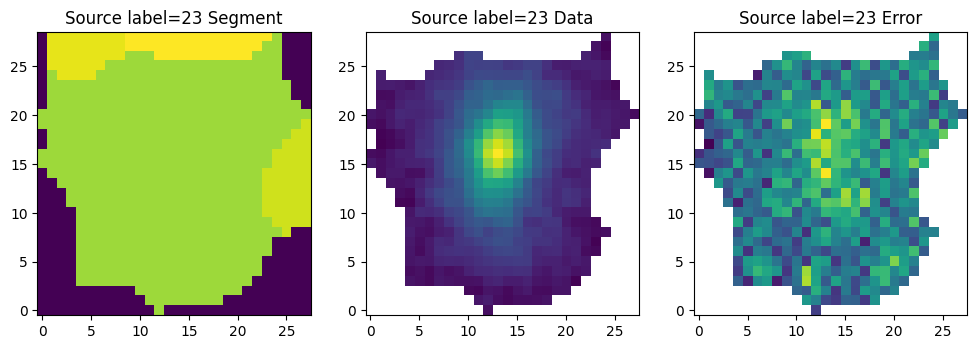

In [43]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(obj.segment)
ax[0].set_title('Source label={} Segment'.format(obj.label))
ax[1].imshow(obj.data_ma)
ax[1].set_title('Source label={} Data'.format(obj.label))
ax[2].imshow(obj.error_ma)
ax[2].set_title('Source label={} Error'.format(obj.label));

Finally, let's plot the bounding box for this source on the data.

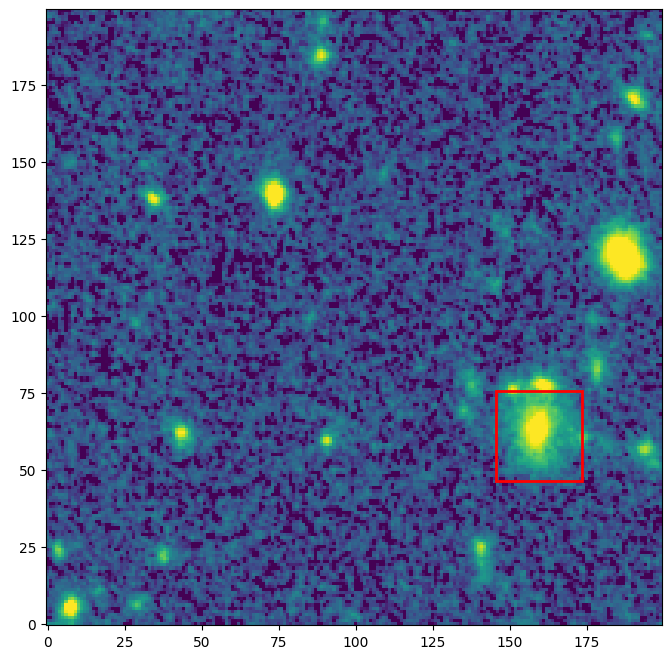

In [44]:
plt.figure(figsize=(8, 8))
plt.imshow(data, norm=norm)
obj.bbox.plot(color='red', lw=2)

## Exercise 1

The [**data/**](data) subdirectory also contains a WFC3/IR F105W image of the same field used for the preceding examples. The F105W and F160W images are pixel aligned, so sources in the F105W image are located at the same pixel positions as the F160W image (if they are visible in the F105W image).

Calculate the F105W isophotal fluxes using the source segments defined by the F160W detection image.

Hints:

* Because the images are pixel aligned, the F160W segmentation image can be directly applied to the F105W image.

* We previously saved the F160W segmentation image in a file called `xdf_f160w_segm.fits`.

* The isophotal fluxes are found in the `segment_flux` attribute of the `SourceCatalog`.

If you prefer to load the solution, uncomment the line below and run the cell twice (once to load the solution and once more to run it).

In [ ]:
# %load 04-segmentation_exercise1_solution

## Exercise 2

Calculate the $Y_{105} - H_{160}$ (F105W $-$ F160W) isophotal colors for all sources detected in the F160W image.  Which sources have the three reddest $Y_{105} - H_{160}$ colors?

The WFC3/IR F105W and F160W AB magnitude zero points are `26.2687` and `25.9463`, respectively.

Hints:

* We previously saved the F160W source catalog table in a file called `xdf_f160w_catalog.ecsv`.

If you prefer to load the solution, uncomment the line below and run the cell twice (once to load the solution and once more to run it).

In [ ]:
# %load 04-segmentation_exercise2_solution

<div class="alert alert-warning alert-block">
<h3 style='margin-top: 0;'>Learn More</h3>

The [PSF photometry](05-psf_photometry.ipynb) notebook covers:

- PSF photometry using simulated 2D Gaussian PSFs, using:
  - BasicPSFPhotometry
  - IterativelySubtractedPSFPhotometry
  - DAOPhotPSFPhotometry
</div>